# Project 6: Analyzing Stock Sentiment from Twits
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Load Packages

In [1]:
import json
import nltk
import os
import random
import re
import torch

from torch import nn, optim
import torch.nn.functional as F

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [2]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'twits.json'), 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

### Length of Data
Now let's look at the number of twits in dataset. Print the number of twits below.

In [3]:
"""print out the number of twits"""

# TODO Implement 

print(f"Total twits: {len(twits['data'])}")

Total twits: 1548010


### Split Message Body and Sentiment Score

In [4]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.

The easiest way to remove specific words or phrases is with regex using the `re` module. You can sub out specific patterns with a space:

```python
re.sub(pattern, ' ', text)
```
This will substitute a space with anywhere the pattern matches in the text. Later when we tokenize the text, we'll split appropriately on those spaces.

### Pre-Processing

In [5]:
nltk.download('wordnet')


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    #TODO: Implement 
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(r'http[^\s]+', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r'\$[^\s]+', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r'\@[^\s]+', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub(r'[^a-z]', ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(wnl.lemmatize(w, 'n'), 'v') for w in tokens if len(w) > 1]
    
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Apply the function `preprocess` to all the twit messages.

In [6]:
# TODO Implement

tokenized = [preprocess(msg) for msg in messages]

In [7]:
for i in range(3):
    print(f'Message:\t{messages[i]}')
    print(f'Tokenized:\t{tokenized[i]}\n')
    
print(len(tokenized))


Message:	$FITB great buy at 26.00...ill wait
Tokenized:	['great', 'buy', 'at', 'ill', 'wait']

Message:	@StockTwits $MSFT
Tokenized:	[]

Message:	#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating
Tokenized:	['staanalystalert', 'for', 'jefferies', 'maintain', 'with', 'rat', 'of', 'hold', 'set', 'target', 'price', 'at', 'usd', 'our', 'own', 'verdict', 'be', 'buy']

1548010


### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [8]:
from collections import Counter


"""
Create a vocabulary by using Bag of words
"""

# TODO: Implement 

bow = Counter(' '.join([' '.join(msg) for msg in tokenized]).split())
len(bow)

90968

### Frequency of Words Appearing in Message
With our vocabulary, now we'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If we can filter these out, then our network should have an easier time learning.

We also want to remove really rare words that show up in a only a few twits. Here you'll want to divide the count of each word by the number of messages. Then remove words that only appear in some small fraction of the messages.

In [9]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# TODO Implement 

bow_tuple_list = [(w, c) for w, c in bow.items()]
sorted_vocab = sorted(bow_tuple_list, key=lambda word: word[1], reverse=True)

total_msgs = len(tokenized)

# Dictionary that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
freqs = {w: c/total_msgs for w, c in bow.items()}

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
min_word_count = 15
low_cutoff = min_word_count / total_msgs
print(low_cutoff)

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = min_word_count

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [t[0] for t in sorted_vocab[:high_cutoff]]

filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
print(K_most_common)
len(filtered_words) 

9.689859884626068e-06
['be', 'the', 'to', 'for', 'on', 'of', 'and', 'in', 'this', 'it', 'at', 'will', 'up', 'buy', 'report']


12895

### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

In [10]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

#TODO Implement

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab = {w: i for i, w in enumerate(filtered_words)}

# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {i: w for w, i in vocab.items() }

# tokenized with the words not in `filtered_words` removed.
filtered = [[w for w in msg if w in filtered_words] for msg in tokenized]  
print(filtered[0])

['great', 'ill', 'wait']


### Balancing the classes
Let's do a few last pre-processing steps. If we look at how our twits are labeled, we'll find that 50% of them are neutral. This means that our network will be 50% accurate just by guessing 0 every single time. To help our network learn appropriately, we'll want to balance our classes.
That is, make sure each of our different sentiment scores show up roughly as frequently in the data.

What we can do here is go through each of our examples and randomly drop twits with neutral sentiment. What should be the probability we drop these twits if we want to get around 20% neutral twits starting at 50% neutral? We should also take this opportunity to remove messages with length 0.

In [11]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)
keep_prob = (N_examples - n_neutral)/4/n_neutral

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

If you did it correctly, you should see the following result 

In [12]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.19447426380777103

Finally let's convert our tokens into integer ids which we can pass to the network.

In [13]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

## Neural Network
Now we have our vocabulary which means we can transform our tokens into ids, which are then passed to our network. So, let's define the network now!

Here is a nice diagram showing the network we'd like to build: 

#### Embed -> RNN -> Dense -> Softmax
### Implement the text classifier
Before we build text classifier, if you remember from the other network that you built in  "Sentiment Analysis with an RNN"  exercise  - which there, the network called " SentimentRNN", here we named it "TextClassifer" - consists of three main parts: 1) init function `__init__` 2) forward pass `forward`  3) hidden state `init_hidden`. 

This network is pretty similar to the network you built expect in the  `forward` pass, we use softmax instead of sigmoid. The reason we are not using sigmoid is that the output of NN is not a binary. In our network, sentiment scores have 5 possible outcomes. We are looking for an outcome with the highest probability thus softmax is a better choice.

In [14]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        
        # TODO Implement

        # Setup embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        
        # Setup additional layers
        self.lstm = nn.LSTM(self.embed_size, self.lstm_size, self.lstm_layers, dropout=self.dropout, batch_first=False)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.lstm_size, self.output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        
        Parameters
        ----------
            batch_size : The size of batches.
        
        Returns
        -------
            hidden_state
            
        """
        
        # TODO Implement 
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        
        weights = next(self.parameters()).data
        
        hidden = (weights.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weights.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden


    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of our model on nn_input.
        
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.

        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.

        """
        
        # TODO Implement
        
        batch_size = nn_input.size(1)
        
        embed_out = self.embedding(nn_input)
        lst_out, hidden_state = self.lstm(embed_out, hidden_state)
        #stack up lstm outputs
        
        #lst_out = lst_out.contiguous().view(-1, self.lstm_size)
        lst_out = lst_out[-1,:,:]
        
        out = self.fc(self.dropout(lst_out))
        sig_out = self.logsoftmax(out)
        
        return sig_out, hidden_state

### View Model

In [15]:
model = TextClassifier(len(vocab), 10, 6, 5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
hidden = model.init_hidden(4)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.5783, -1.4312, -2.0914, -1.5418, -1.5273],
        [-1.7476, -1.4039, -1.9812, -1.6009, -1.4247],
        [-1.8314, -1.3922, -1.9318, -1.4609, -1.5400],
        [-1.7007, -1.4012, -1.9812, -1.4390, -1.6293]])


## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [16]:
def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [17]:
"""
Split data into training and validation datasets. Use an appropriate split size.
The features are the `token_ids` and the labels are the `sentiments`.
"""   

# TODO Implement 

split_size = int(len(token_ids)*0.8)

train_features = token_ids[:split_size]
valid_features = token_ids[split_size:]
train_labels = sentiments[:split_size]
valid_labels = sentiments[split_size:]

In [18]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=20, batch_size=64)))
model = TextClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
hidden = model.init_hidden(64)
logps, hidden = model.forward(text_batch, hidden)

### Training
It's time to train the neural network!

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(12896, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (logsoftmax): LogSoftmax()
)

In [20]:
"""
Train your model with dropout. Make sure to clip your gradients.
Print the training loss, validation loss, and validation accuracy for every 100 steps.
"""

epochs = 2
batch_size = 128
learning_rate = 0.0005

print_every = 100
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    
    steps = 0
    train_loss = 0
    
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        steps += 1
        
        # TODO Implement: Train Model
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        
        hidden = model.init_hidden(labels.shape[0])
        for state in hidden:
            state.to(device)
        
        optimizer.zero_grad()
        
        logs_ps, hidden = model(text_batch, hidden)
        
        loss = criterion(logs_ps, labels)
        loss.backward()
        
        # clip gradient
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
        train_loss += loss
        
        
        if steps % print_every == 0:
            model.eval()
            
            # TODO Implement: Print metrics
            
            with torch.no_grad():
                
                val_loss = 0
                val_accuracy = 0
                val_steps = 0
            
                val_loader = dataloader(valid_features, 
                                        valid_labels, 
                                        batch_size=batch_size, 
                                        sequence_length=20, 
                                        shuffle=True)

                for val_text_batch, val_labels in val_loader:
                    
                    val_steps += 1

                    # Set Device
                    val_text_batch, val_labels = val_text_batch.to(device), val_labels.to(device)

                    val_hidden = model.init_hidden(val_labels.shape[0])
                    for state in val_hidden:
                        state.to(device)

                    val_log_ps, val_hidden = model(val_text_batch, val_hidden)

                    ps = torch.exp(val_log_ps)
                    val_loss += criterion(val_log_ps, val_labels)

                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == val_labels.view(*top_class.shape)
                    val_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            train_losses.append(train_loss/print_every)
            val_losses.append(val_loss/val_steps)
            val_accuracies.append(val_accuracy/val_steps)

            print(f'Epoch: {epoch+1}/{epochs}    ',
                  f'Step: {steps}    ', 
                  f'Train_loss: {train_losses[-1]:.4f}    ', 
                  f'Val_loss: {val_losses[-1]:.4f}    ',
                  f'Val_accuracy: {val_accuracies[-1]:.4f}')
            
            train_loss = 0

            model.train()

Starting epoch 1
Epoch: 1/2     Step: 100     Train_loss: 1.3441     Val_loss: 1.2241     Val_accuracy: 0.4886
Epoch: 1/2     Step: 200     Train_loss: 1.1466     Val_loss: 1.1358     Val_accuracy: 0.5273
Epoch: 1/2     Step: 300     Train_loss: 1.0778     Val_loss: 1.0851     Val_accuracy: 0.5571
Epoch: 1/2     Step: 400     Train_loss: 1.0171     Val_loss: 1.0554     Val_accuracy: 0.5769
Epoch: 1/2     Step: 500     Train_loss: 0.9908     Val_loss: 1.0213     Val_accuracy: 0.5890
Epoch: 1/2     Step: 600     Train_loss: 0.9742     Val_loss: 1.0069     Val_accuracy: 0.5974
Epoch: 1/2     Step: 700     Train_loss: 0.9563     Val_loss: 0.9930     Val_accuracy: 0.5985
Epoch: 1/2     Step: 800     Train_loss: 0.9443     Val_loss: 0.9728     Val_accuracy: 0.6170
Epoch: 1/2     Step: 900     Train_loss: 0.9314     Val_loss: 0.9592     Val_accuracy: 0.6169
Epoch: 1/2     Step: 1000     Train_loss: 0.9103     Val_loss: 0.9573     Val_accuracy: 0.6213
Epoch: 1/2     Step: 1100     Train_loss: 

Epoch: 2/2     Step: 2400     Train_loss: 0.7439     Val_loss: 0.8195     Val_accuracy: 0.6818
Epoch: 2/2     Step: 2500     Train_loss: 0.7512     Val_loss: 0.8249     Val_accuracy: 0.6784
Epoch: 2/2     Step: 2600     Train_loss: 0.7613     Val_loss: 0.8244     Val_accuracy: 0.6787
Epoch: 2/2     Step: 2700     Train_loss: 0.7490     Val_loss: 0.8223     Val_accuracy: 0.6800
Epoch: 2/2     Step: 2800     Train_loss: 0.7484     Val_loss: 0.8192     Val_accuracy: 0.6821
Epoch: 2/2     Step: 2900     Train_loss: 0.7470     Val_loss: 0.8186     Val_accuracy: 0.6823
Epoch: 2/2     Step: 3000     Train_loss: 0.7597     Val_loss: 0.8197     Val_accuracy: 0.6817
Epoch: 2/2     Step: 3100     Train_loss: 0.7471     Val_loss: 0.8189     Val_accuracy: 0.6821
Epoch: 2/2     Step: 3200     Train_loss: 0.7483     Val_loss: 0.8168     Val_accuracy: 0.6831
Epoch: 2/2     Step: 3300     Train_loss: 0.7508     Val_loss: 0.8186     Val_accuracy: 0.6825
Epoch: 2/2     Step: 3400     Train_loss: 0.7451  

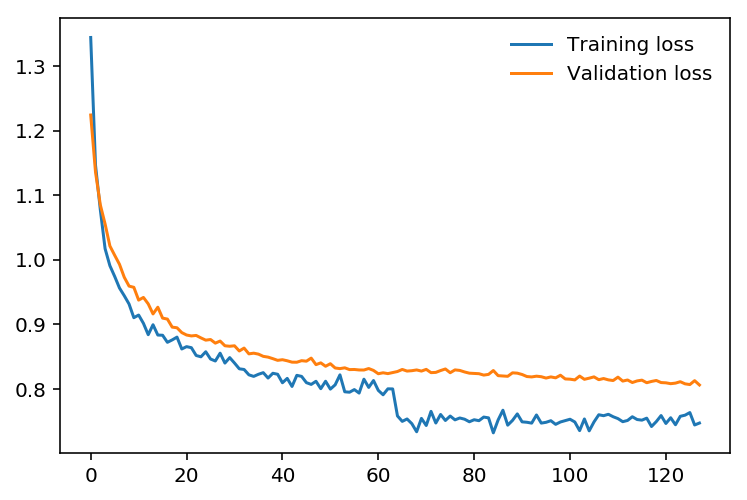

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Making Predictions
### Prediction 
Okay, now that you have a trained model, try it on some new twits and see if it works appropriately. Remember that for any new text, you'll need to preprocess it first before passing it to the network. Implement the `predict` function to generate the prediction vector from a message.

In [22]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    # TODO Implement
    
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [w for w in tokens if w in filtered_words]
    # Convert words to ids
    tokens = [vocab[word] for word in tokens]
        
    # Adding a batch dimension
    text_input = torch.tensor(tokens).unsqueeze(1)
    # Get the NN output
    hidden = model.init_hidden(text_input.size(1))
    logps, _ = model(text_input, hidden)
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.exp(logps)
    
    return pred

In [23]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
model.to("cpu")
predict(text, model, vocab)

tensor([[ 0.0001,  0.0043,  0.0054,  0.7832,  0.2071]])

### Questions: What is the prediction of the model? What is the uncertainty of the prediction?
** TODO: Answer Question**

**Answer:** the output of the model are probabilities of the sentiment classes for an input message. These probabilities sum to 1 and they indicate the degree of belonging of the message to each sentiment class. The sentiment of the input message predicted by the model is giving by the sentiment class with the highest probability. Due to this, we can say that there is an uncertainty in the prediction.

Now we have a trained model and we can make predictions. We can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now we have a stream of twits. For each of those twits, pull out the stocks mentioned in them and keep track of the sentiments. Remember that in the twits, ticker symbols are encoded with a dollar sign as the first character, all caps, and 2-4 letters, like $AAPL. Ideally, you'd want to track the sentiments of the stocks in your universe and use this as a signal in your larger model(s).

## Testing
### Load the Data 

In [24]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'test_twits.json'), 'r') as f:
    test_data = json.load(f)

### Twit Stream

In [25]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [26]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [27]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)

{'symbol': '$AAPL',
 'score': tensor([[ 0.0954,  0.0963,  0.1390,  0.2375,  0.4318]]),
 'timestamp': '2018-11-01T00:00:18Z'}

That's it. You have successfully built a model for sentiment analysis! 

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.